In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" # Delete above if you want to use GPU
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
from scipy.interpolate import UnivariateSpline
html_width(HTML("<style>.container { width:90% !important; }</style>"))

/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

#### The LfD part of the code is taken from https://github.com/rssCNMP/CNMP

## Loading data:
These demonstrations are used in the last experiment of the <b>Adaptive Conditional Neural Movement Primitives (CoRL 2020)</b>
* Y_3 denote training trajectories of 3DOF robot for 3 proxy tasks.
* new_Y_3 denote test trajectory of 3DOF robot for button pressing task.
* Y_4 denote training trajectories of 4DOF robot for 3 proxy tasks.
* new_Y_4 denote test trajectory of 4DOF robot for button pressing task.

In [2]:
Y_3 = np.load("3doftraining_joint_trajectories.npy")
Y_4 = np.load("4doftraining_joint_trajectories.npy")
new_Y_3 = np.load("3dofbuttontotransfer.npy")
new_Y_4 = np.load("4dofbuttongroundtruth.npy")

## Loading model inputs
<b>Input Requirements</b>:

* <b>obs_max</b>: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 12
* <b>d_N</b>: Number of demonstrations

* <b>d_x</b>: X vector feature dim (NOTE THAT: external parameters are assumed to be inside of the X vector, concatenated to time value. This experiment does not use external parameters so d_x = 1)

* <b>d_y</b>: Y vector feature dim

* <b>time_len</b>: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (check numpy.interp)

* <b>X</b>: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters

* <b>obs_mlp_layers</b>: Hidden neuron numbers of the dense layers inside of the Observation multi layer perceptron. Layer numbers can adapt to the list size. Last layer is always Linear, others are ReLU activated.

* <b>decoder_layers</b>: Hidden neuron numbers of the dense layers inside of the Decoder multi layer perceptron. Layer numbers can adapt to the list size. Last layer size is always 2*d_y and activation is Linear, others are ReLU activated.

In [3]:
time_N = 300
times = np.linspace(0.,1.,time_N)
X = np.zeros((12,300,1))

for i in range(12):
    for j in range(300):
        X[i,j,0]=times[j]

obs_max = 12 
d_N = X.shape[0] 
d_x , d_y_3, d_y_4 = (X.shape[-1] , Y_3.shape[-1],Y_4.shape[-1] )
time_len = X.shape[1] 
obs_mlp_layers = [128,128,128,64]
decoder_layers_3 = [128,128,128,128,d_y_3*2]
decoder_layers_4 = [128,128,128,128,d_y_4*2]


print ('d_N =', d_N)
print ('obs_max =', obs_max)

print ('d_x=',d_x)
print ('d_y_3 =',d_y_3)
print ('d_y_4 =',d_y_4)
print ('time_len =', time_len) 

d_N = 12
obs_max = 12
d_x= 1
d_y_3 = 3
d_y_4 = 4
time_len = 300


In [4]:
print(np.shape(Y_3))
print(np.shape(Y_4))
print(np.shape(new_Y_3))
print(np.shape(new_Y_4))


(12, 300, 3)
(12, 300, 4)
(1, 300, 3)
(1, 300, 4)


# Adaptive Conditional Neural Movement Primitives for skill transfer

### <b>get_train_sample()</b>: 
* Selects two random observation number, n1 and nr for two robots
* Selects a random demonstration id, d
* Permutes demonstration d differently two times for two robots, so the first n data can be observation. Selects (n+1)th data to be the target point
* Returns observations and target_X arrays as inputs to the model to predict target_Y arrays

In [5]:
def get_train_sample():
    n1 = np.random.randint(8,obs_max)+1
    n2 = np.random.randint(8,obs_max)+1
    d = np.random.randint(0, d_N)
    observation_3 = np.zeros((1,n1,d_x+d_y_3))
    observation_4 = np.zeros((1,n2,d_x+d_y_4))
    
    target_X_3 = np.zeros((1,1,d_x))
    target_Y_3 = np.zeros((1,1,d_y_3*2))
    
    target_X_4 = np.zeros((1,1,d_x))
    target_Y_4 = np.zeros((1,1,d_y_4*2))
    
    perm = np.random.permutation(time_len)
    perm4 = np.random.permutation(time_len)
    
    observation_3[0,:n1,:d_x] = X[d,perm[:n1]]
    observation_3[0,:n1,d_x:d_x+d_y_3] = Y_3[d,perm[:n1]]
    
    observation_4[0,:n2,:d_x] = X[d,perm4[:n2]]
    observation_4[0,:n2,d_x:d_x+d_y_4] = Y_4[d,perm4[:n2]]
    
    target_X_3[0,0] = X[d,perm[n1]]
    target_Y_3[0,0,:d_y_3] = Y_3[d,perm[n1]]
    
    target_X_4[0,0] = X[d,perm4[n2]]
    target_Y_4[0,0,:d_y_4] = Y_4[d,perm4[n2]]
    
    return [observation_3,observation_4,target_X_3,target_X_4], [target_Y_3, target_Y_4]

#### get_train_sample() for 3DOF robot in case of a need for separate training

In [6]:
def get_train_sample2():
    n = np.random.randint(8,obs_max)+1
    d = 0
    observation_3 = np.zeros((1,n,d_x+d_y_3))
    
    target_X_3 = np.zeros((1,1,d_x))
    target_Y_3 = np.zeros((1,1,d_y_3*2))
      
    perm = np.random.permutation(time_len)

    
    observation_3[0,:n,:d_x] = X[d,perm[:n]]
    observation_3[0,:n,d_x:d_x+d_y_3] = new_Y_3[d,perm[:n]]
    
    target_X_3[0,0] = X[d,perm[n]]
    target_Y_3[0,0,:d_y_3] = new_Y_3[d,perm[n]]
    
    return [observation_3,target_X_3], target_Y_3

#### get_train_sample() for 4DOF robot in case of a need for separate training

In [7]:
def get_train_sample3():
    n = np.random.randint(8,obs_max)+1
    d = np.random.randint(0, d_N)
    observation_4 = np.zeros((1,n,d_x+d_y_4))
    
    target_X_4 = np.zeros((1,1,d_x))
    target_Y_4 = np.zeros((1,1,d_y_4*2))
      
    perm = np.random.permutation(time_len)

    
    observation_4[0,:n,:d_x] = X[d,perm[:n]]
    observation_4[0,:n,d_x:d_x+d_y_4] = Y_4[d,perm[:n]]
    
    target_X_4[0,0] = X[d,perm[n]]
    target_Y_4[0,0,:d_y_4] = Y_4[d,perm[n]]
    
    return [observation_4,target_X_4], target_Y_4

### custom_loss():
* Calculates log probability of the true value of the target point according to the multivariate Gaussian constructed by predicted means and stds
* Returns minus of that value

In [8]:
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

### MLP():

* Constructs a multilayer perceptron according to the given input dimension and layer sizes.
* <b>input_dim</b>: dimension of the input feature vector
* <b>layers</b>: Constructs a dense layer for each number in the list. Layer numbers are flexible to list size. Except for the last layer, all layers are ReLU activated.
  * ex: (2,[128,128,128]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (2->128->128->128) from input to output
  * ex: (4,[128,4]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (4->128->4) from input to output
* <b>parallel_input</b>:
  * if <b>False</b>, MLP acts as classical fully connected MLP. Output is a single result.
  * if <b>True</b>, MLP acts as a single parameter-sharing network. Every tuple in the input batch passes through MLP paralelly, independently from each other. Output is a batch which every row is the result of the corresponding tuple from the input batch passing through the parameter-sharing network.
  * <b>TLDR;</b> use parallel input for encoding observations into representations, and fully connected MLP for every any other dense networks.

In [9]:
def MLP(input_dim, layers, name="mlp", parallel_inputs=False):
    input_layer = Input(shape=(None, input_dim),name=name+'_input')
    for i in range(len(layers)-1):
        hidden = TimeDistributed(Dense(layers[i], activation='relu'), name=name+'_'+str(i))(input_layer if i == 0 else hidden) if parallel_inputs else Dense(layers[i], activation='relu', name=name+'_'+str(i))(input_layer if i == 0 else hidden)
    hidden = TimeDistributed(Dense(layers[-1]), name=name+'_output')(hidden) if parallel_inputs else Dense(layers[-1], name=name+'_output')(hidden)
    return Model(input_layer, hidden, name=name)

## CNMP model:

<p>
As proposed in the paper, the model is created. Layers can be tracked from figure below:
<br>
<img src="CNP.png" width=500 align="left">
</p>





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_3 (InputLayer)      (None, None, 4)      0                                            
__________________________________________________________________________________________________
obs_mlp_3 (Model)               (None, None, 64)     41920       observation_3[0][0]              
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 64)           0           obs_mlp_3[1][0]                  
__________________________________________________________________________________________________
target_3 (InputLayer)           (None, None, 1)      0                                            
________________________________________________________________________________________

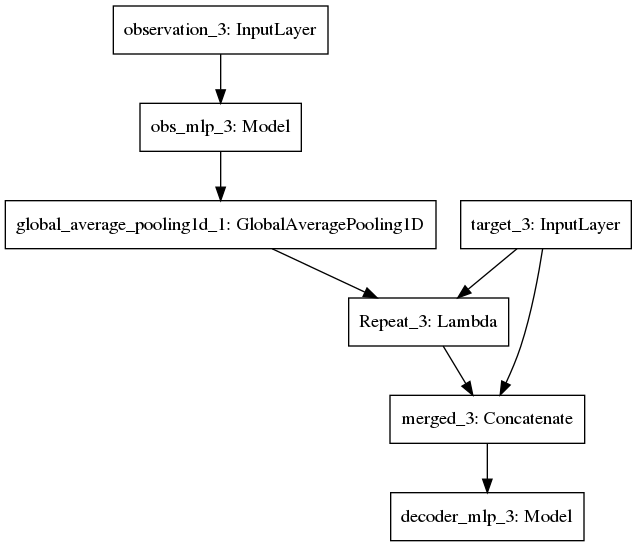

In [10]:
#Model for 3Dof Robot

observation_layer_3 = Input(shape=(None,d_x+d_y_3), name="observation_3") # (x_o,y_o) tuples
target_X_layer_3 = Input(shape=(None,d_x), name="target_3") # x_q

ObsMLP_3 = MLP(d_x+d_y_3, obs_mlp_layers, name='obs_mlp_3', parallel_inputs=True) # Network E
obs_representations_3 = ObsMLP_3(observation_layer_3) # r_i
general_representation_3 = GlobalAveragePooling1D()(obs_representations_3) # r
general_representation_3 = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat_3')([general_representation_3,target_X_layer_3]) # r in batch form (same)

merged_layer_3 = Concatenate(axis=2, name='merged_3')([general_representation_3,target_X_layer_3]) # (r,x_q) tuple
Decoder_3 = MLP(d_x+obs_mlp_layers[-1], decoder_layers_3, name = 'decoder_mlp_3', parallel_inputs=False) # Network Q
output_3 = Decoder_3(merged_layer_3) # (mean_q, std_q)

model_3 = Model([observation_layer_3, target_X_layer_3],output_3)
model_3.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model_3.summary()

rep_model_3 = Model([observation_layer_3, target_X_layer_3],general_representation_3)

plot_model(model_3)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_4 (InputLayer)      (None, None, 5)      0                                            
__________________________________________________________________________________________________
obs_mlp_4 (Model)               (None, None, 64)     42048       observation_4[0][0]              
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 64)           0           obs_mlp_4[1][0]                  
__________________________________________________________________________________________________
target_4 (InputLayer)           (None, None, 1)      0                                            
____________________________________________________________________________________________

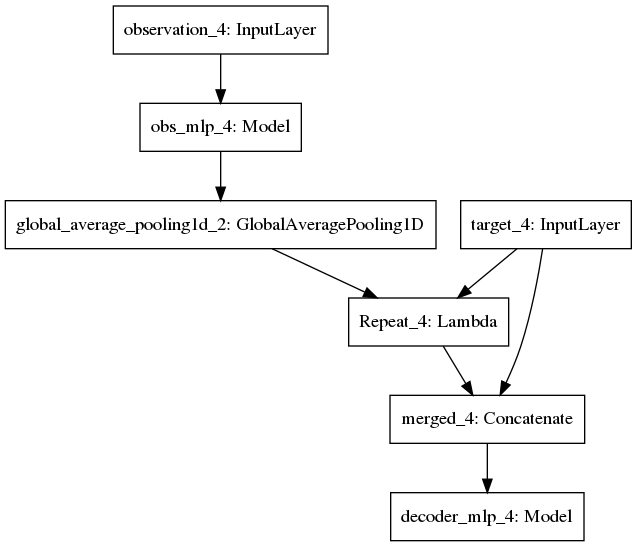

In [11]:
#Model for 4Dof Robot

observation_layer_4 = Input(shape=(None,d_x+d_y_4), name="observation_4") # (x_o,y_o) tuples
target_X_layer_4 = Input(shape=(None,d_x), name="target_4") # x_q

ObsMLP_4 = MLP(d_x+d_y_4, obs_mlp_layers, name='obs_mlp_4', parallel_inputs=True) # Network E
obs_representations_4 = ObsMLP_4(observation_layer_4) # r_i
general_representation_4 = GlobalAveragePooling1D()(obs_representations_4) # r
general_representation_4 = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat_4')([general_representation_4,target_X_layer_4]) # r in batch form (same)

merged_layer_4 = Concatenate(axis=2, name='merged_4')([general_representation_4,target_X_layer_4]) # (r,x_q) tuple
Decoder_4 = MLP(d_x+obs_mlp_layers[-1], decoder_layers_4, name = 'decoder_mlp_4', parallel_inputs=False) # Network Q
output_4 = Decoder_4(merged_layer_4) # (mean_q, std_q)

model_4 = Model([observation_layer_4, target_X_layer_4],output_4)
model_4.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model_4.summary()

rep_model_4 = Model([observation_layer_4, target_X_layer_4],general_representation_4)

plot_model(model_4)

In [12]:
decoderinputmodel_3 = Model([observation_layer_3, target_X_layer_3],merged_layer_3)
decoderinputmodel_4 = Model([observation_layer_4, target_X_layer_4],merged_layer_4)


In [13]:
plot_model(Decoder_4)
Decoder_4.summary()

Model: "decoder_mlp_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_mlp_4_input (InputLa (None, None, 65)          0         
_________________________________________________________________
decoder_mlp_4_0 (Dense)      (None, None, 128)         8448      
_________________________________________________________________
decoder_mlp_4_1 (Dense)      (None, None, 128)         16512     
_________________________________________________________________
decoder_mlp_4_2 (Dense)      (None, None, 128)         16512     
_________________________________________________________________
decoder_mlp_4_3 (Dense)      (None, None, 128)         16512     
_________________________________________________________________
decoder_mlp_4_output (Dense) (None, None, 8)           1032      
Total params: 59,016
Trainable params: 59,016
Non-trainable params: 0
_________________________________________________

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_3 (InputLayer)      (None, None, 4)      0                                            
__________________________________________________________________________________________________
observation_4 (InputLayer)      (None, None, 5)      0                                            
__________________________________________________________________________________________________
obs_mlp_3 (Model)               (None, None, 64)     41920       observation_3[0][0]              
__________________________________________________________________________________________________
obs_mlp_4 (Model)               (None, None, 64)     42048       observation_4[0][0]              
____________________________________________________________________________________________

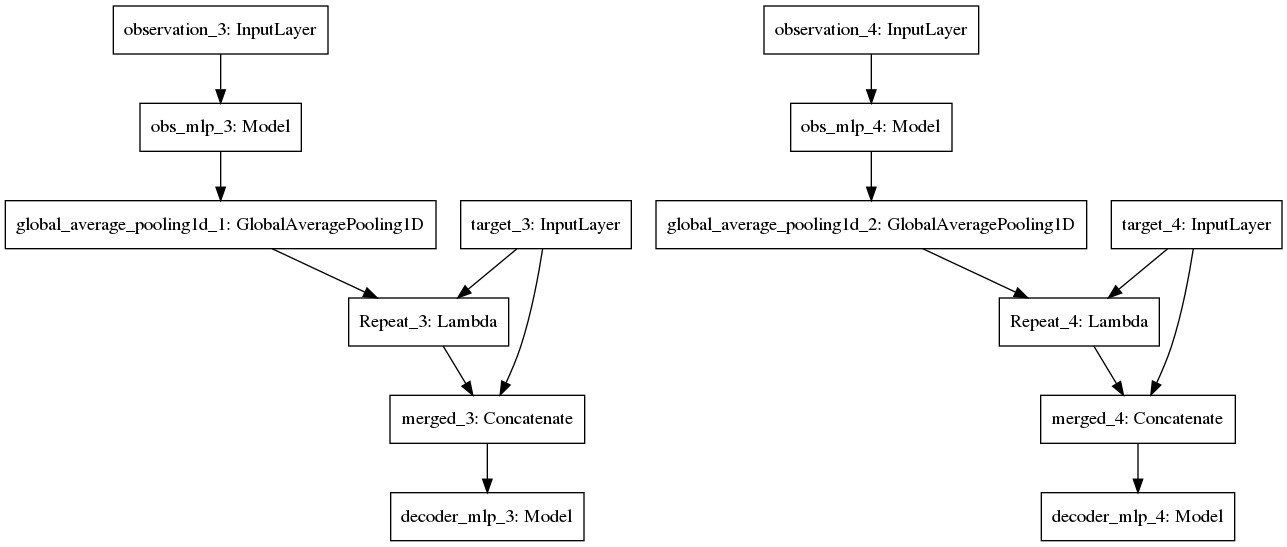

In [14]:
#Unifiying model

correlation_loss = K.mean(K.square(general_representation_3-general_representation_4))*5000000

model = Model([observation_layer_3,observation_layer_4, target_X_layer_3, target_X_layer_4], [output_3,output_4])
model.add_loss(correlation_loss)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()
plot_model(model)

In [15]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

## T-SNE method is used to show common latent space. This function plots and saves the images

In [16]:
def plot_representation(step):
    reps3=np.zeros((400,64))
    reps4=np.zeros((400,64))
    color_intermediates=[]
    for i in range(800):
        if i<400:
            color_intermediates.append("#0000ff")
        else:
            color_intermediates.append("#ff0000")    

    for i in range(400):
        a,b=get_train_sample()
        c=[a[0],a[2]]
        d=b[0]
        e=[a[1],a[3]]
        reps3[i]=rep_model_3.predict(c)[0][0]
        reps4[i]=rep_model_4.predict(e)[0][0]

    reps=np.concatenate((reps3,reps4),axis=0)

    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    intermediates_tsne = tsne.fit_transform(reps)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1], color=color_intermediates)
    plt.xlabel('Latent dimension 1', fontsize=14)
    plt.ylabel('Latent dimension 2', fontsize=14)
    plt.title('Latent representation', fontsize=16)
    #plt.savefig('latent_images/transferlearningrepresentationinitial{:d}.png'.format(step),bbox_inches='tight')
    plt.savefig('latent_images/transferlearningrepresentationinitial{:d}.svg'.format(step),bbox_inches='tight', format = "svg")
    plt.show()


### generator():

* Generates data using get_train_sample function during training

In [17]:
def generator():
    while True:
        inp,out = get_train_sample()
        yield (inp, out)

### CNMP_Callback:

* CNMP_Callback is a customizable class that manages the CNMP training process.

  
  

In [18]:
class CNMP_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 10000
        self.validation_checkpoint = 100
        self.validation_error = 9999999
        return

    def on_batch_end(self, batch, logs={}):
        
        if self.step % 4000 == 0:
            print (' Validation error:  ', self.validation_error)
       
        if self.step % self.validation_checkpoint == 0:
            
            current_error = 0
            for i in range(50):
                inp,out  = get_train_sample2()
                observation = inp[0]

                times2=times.reshape(1,time_len,d_x)

                prediction_3 = model_3.predict([observation,times2])[0]
                predicted_Y_3 = prediction_3[:,:d_y_3]
                current_error += np.mean((predicted_Y_3 - new_Y_3[0,:])**2) #/ 300

            if current_error < self.validation_error:
                self.validation_error = current_error
                model.save('transfermodel_best_validation.h5')
                model_3.save('transfermodel3_best_validation.h5')
                model_4.save('transfermodel4_best_validation.h5')
                print (' New validation best. Error is ', current_error)
            
        if self.step % self.loss_checkpoint == 0:
            

            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print (self.step)
            
                       
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            #plotting training and smoothed losses
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            plt.title('Train Loss')
            plt.plot(range(len(self.losses)),self.losses)
            plt.subplot(122)
            plt.title('Train Loss (Smoothed)')
            plt.plot(range(len(self.smooth_losses)),self.smooth_losses)
            plt.show()
            
            
            if self.step!=0:
                self.smooth_losses.append(0)
                
        if self.step % 100000 == 0:
            plot_representation(self.step)
            
            
        self.step += 1
        return

### Starting the training

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

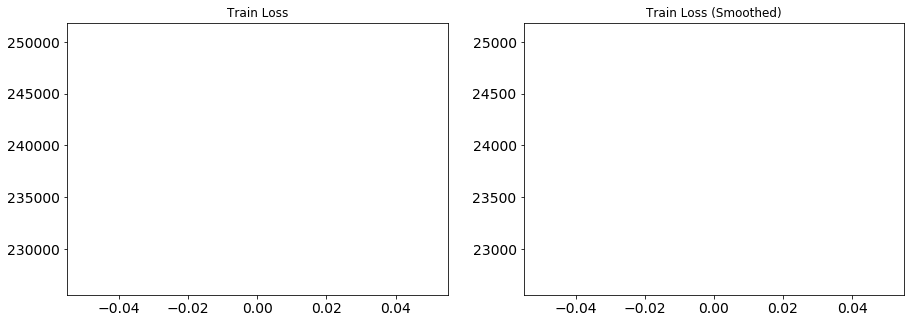

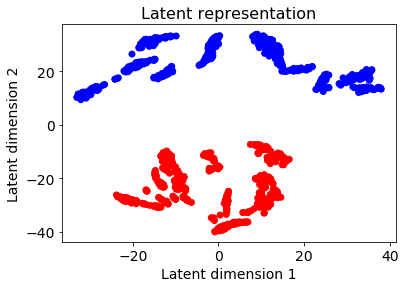

    84/500000 [..............................] - ETA: 8:10:10 - loss: 43231.0853 - decoder_mlp_3_loss: 4.2759 - decoder_mlp_4_loss: 9.8301 

/home/tuluhan/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (3.856449). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/home/tuluhan/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.928481). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 New validation best. Error is  30.06406341221353
   131/500000 [..............................] - ETA: 5:27:11 - loss: 28968.2599 - decoder_mlp_3_loss: 3.9771 - decoder_mlp_4_loss: 9.1676

KeyboardInterrupt: 

In [19]:
max_training_step = 500000
model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[CNMP_Callback()])

### Loading the Best Model 

In [ ]:
model.load_weights('transfermodel_best_validation.h5') 
model_3.load_weights('transfermodel3_best_validation.h5') 
model_4.load_weights('transfermodel4_best_validation.h5') 

### Loading the trained model

In [20]:
model.load_weights('transfermodel_best_training.h5') 
model_3.load_weights('transfermodel3_best_training.h5') 
model_4.load_weights('transfermodel4_best_training.h5') 

#### Weights of decoder is saved for RL part

In [21]:
Decoder_4.save('decoder4_weights_2.h5')

#### Policy gradient loss

In [22]:
import keras.backend as K
def custom_loss2(taken, predicted):
    predicted_action_mean, predicted_action_sigma = tf.split(predicted, 2, axis=-1)
    taken_action, q_value =tf.split(taken,2,axis=-1)
    #q1,_,_,_,_,_ = tf.split(q_value,6,axis=-1)
    #sigma = tf.nn.softplus(predicted_action_sigma)
    square_loss=tf.math.square(taken_action-predicted_action_mean)
    loss=(1./4.)*tf.math.multiply(square_loss,q_value)
    print(np.shape(loss))
    return K.mean(loss)

### RL agent

In [23]:
reps_layer = Input(shape=(None,65))
decoder = Dense(128, activation='relu')(reps_layer)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(8)(decoder)

model2 = Model(inputs= reps_layer,outputs=output_layer)
model2.compile(optimizer = Adam(lr = 1e-5),loss=custom_loss2)
model2.summary()

(?, ?, 4)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 65)          0         
_________________________________________________________________
dense_9 (Dense)              (None, None, 128)         8448      
_________________________________________________________________
dense_10 (Dense)             (None, None, 128)         16512     
_________________________________________________________________
dense_11 (Dense)             (None, None, 128)         16512     
_________________________________________________________________
dense_12 (Dense)             (None, None, 128)         16512     
_________________________________________________________________
dense_13 (Dense)             (None, None, 8)           1032      
Total params: 59,016
Trainable params: 59,016
Non-trainable params: 0
_____________________________________________

In [24]:
model2.load_weights('decoder4_weights_2.h5')

## Prediction result after the transfer for 3 DOF and 4 DOF robot using observations from 3DOF's trajectory

(300,)


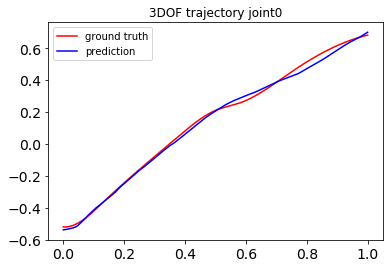

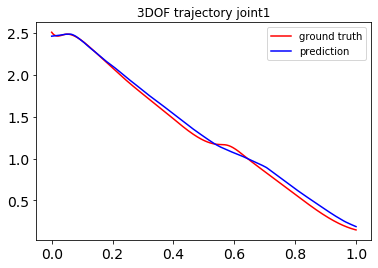

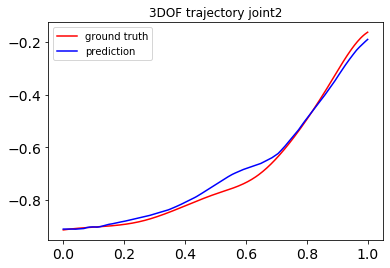

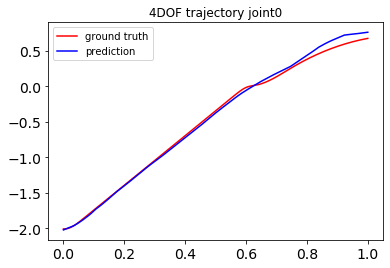

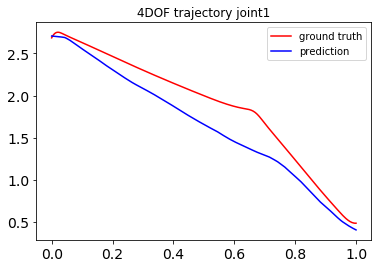

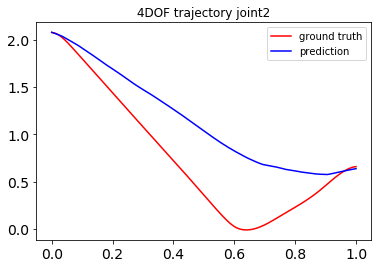

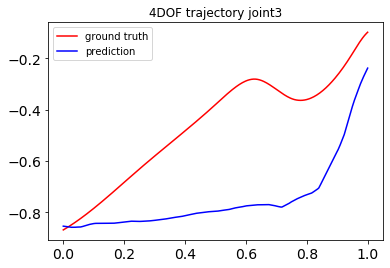

In [25]:
for test_num in range(1):
    new_observation_3 = np.zeros((1,11,d_x+d_y_3))

    new_observation_3[0,0,:d_x] = X[0,0]
    new_observation_3[0,0,d_x:d_x+d_y_3] = new_Y_3[test_num,0]

    new_observation_3[0,1,:d_x] = X[0,29]
    new_observation_3[0,1,d_x:d_x+d_y_3] = new_Y_3[test_num,29]

    new_observation_3[0,2,:d_x] = X[0,59]
    new_observation_3[0,2,d_x:d_x+d_y_3] = new_Y_3[test_num,59]

    new_observation_3[0,3,:d_x] = X[0,89]
    new_observation_3[0,3,d_x:d_x+d_y_3] = new_Y_3[test_num,89]

    new_observation_3[0,4,:d_x] = X[0,119]
    new_observation_3[0,4,d_x:d_x+d_y_3] = new_Y_3[test_num,119]

    new_observation_3[0,5,:d_x] = X[0,149]
    new_observation_3[0,5,d_x:d_x+d_y_3] = new_Y_3[test_num,149]

    new_observation_3[0,6,:d_x] = X[0,179]
    new_observation_3[0,6,d_x:d_x+d_y_3] = new_Y_3[test_num,179]

    new_observation_3[0,7,:d_x] = X[0,209]
    new_observation_3[0,7,d_x:d_x+d_y_3] = new_Y_3[test_num,209]

    new_observation_3[0,8,:d_x] = X[0,239]
    new_observation_3[0,8,d_x:d_x+d_y_3] = new_Y_3[test_num,239]

    new_observation_3[0,9,:d_x] = X[0,269]
    new_observation_3[0,9,d_x:d_x+d_y_3] = new_Y_3[test_num,269]

    new_observation_3[0,10,:d_x] = X[0,299]
    new_observation_3[0,10,d_x:d_x+d_y_3] = new_Y_3[test_num,299]

    #print(new_observation_3)

    times2=times.reshape(1,time_len,d_x)

    prediction_3 = model_3.predict([new_observation_3,times2])[0]
    predicted_Y_3 = prediction_3[:,:d_y_3]

    print(np.shape(times))
    for xyz in range(3):
        #plt.plot(times,Y_3[test_num,:,xyz],'r')
        plt.plot(times,new_Y_3[0,:,xyz],'r', label = "ground truth")
        plt.plot(times,predicted_Y_3[:,xyz],'b' , label = "prediction")
        plt.title("3DOF trajectory joint{:d}".format(xyz))
        plt.legend()
        plt.show()

    r3=decoderinputmodel_3.predict([new_observation_3,times2])
    prediction_4 = Decoder_4.predict(r3)[0]
    predicted_Y_4 = prediction_4[:,:d_y_4]

    for xyz in range(4):
        #plt.plot(times,Y_4[test_num,:,xyz],'r')
        plt.plot(times,new_Y_4[0,:,xyz],'r', label = "ground truth")
        plt.plot(times,predicted_Y_4[:,xyz],'b', label = "prediction")
        plt.title("4DOF trajectory joint{:d}".format(xyz))
        plt.legend()
        plt.show()

## Simulation Part

In [26]:
from pyrep import PyRep
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.errors import ConfigurationPathError
import time

In [27]:
from pyrep.robots.arms.arm import Arm

class Trobot(Arm):

    def __init__(self, count: int = 0):
        super().__init__(count, 'Trobot', num_joints=4)

In [29]:

pr = PyRep()
# Launch the application with a scene file in headless mode
pr.launch('button_scene.ttt', headless=False) 
pr.start()  # Start the simulation

# Do some stuff

In [30]:
pr.start()

In [31]:
Threedof_starting_position = [-0.50009131,  2.42891255, -0.91733952]

In [32]:
Fourdof_starting_position = [-2.009371280670166, 2.609989881515503, 2.071058750152588, -0.8597654032707214]

### Environment is created dynamically

In [ ]:
agent_model = pr.import_model('Trobot4dofbutton-2.ttm')
agent=Trobot()
pr.step()

agent.set_joint_positions(Fourdof_starting_position)
for i in range(10):
    pr.step()

wall_object1 = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,0], size=[0.015, 0.355, 0.184],
                          position=[0.33,-0.3112, 0.13], orientation=[0,0,-0.35],
                               static=True, respondable=True)

wall_object2 = Shape.create(type=PrimitiveShape.CUBOID, 
                      color=[0,0,0], size=[0.015, 0.355, 0.184],
                      position=[0.46466,0.0588,0.13], orientation=[0,0,-0.35],
                           static=True, respondable=True)


cylinder_object_position = [0.4,-0.124,0.122]
end_goal_position = [0.445,-0.146,0.125]


target_object = Shape.create(type=PrimitiveShape.CUBOID, 
                      color=[0,0,1], size=[0.018, 0.018, 0.018],
                      position=cylinder_object_position, orientation=[0,0,-0.35])


goal_pos = Shape.create(type=PrimitiveShape.CUBOID, 
                      color=[1,0,0], size=[0.03, 0.03, 0.03],
                      position=end_goal_position, orientation=[0,0,-0.35],
                           static=True, respondable=False)
pr.step()

In [ ]:
pr.step()

### The environment can be deleted here as well

In [ ]:
agent_model.remove()
target_object.remove()
wall_object1.remove()
wall_object2.remove()
pr.step()
goal_pos.remove()
pr.step()


### States and initial trajectory are created

In [33]:
r3=decoderinputmodel_3.predict([new_observation_3,times2])
#prediction_4 = Decoder_4.predict(r3)[0]
#predicted_Y_4 = prediction_4[:,:d_y_4]
pr_y = np.zeros((300,4))
print(np.shape(r3))
states = r3.reshape(time_N,1,65)
print(np.shape(states))
print(np.shape(prediction_4))
for i in range(300):
    prr=model2.predict([[states[i]]])[0][0]
    pr_y[i] =  prr[:d_y_4]

(1, 300, 65)
(300, 1, 65)
(300, 8)


### Visualization of initial trajectory

In [ ]:
for j in range (300):
   
    agent.set_joint_target_positions(pr_y[j])
    pr.step()
    pr.step()
    pr.step()
    pr.step()


In [35]:
pr.step()

In [ ]:
pr.stop()

In [34]:
pr.start()

In [ ]:
#pr.shutdown()

### The rest of the code is similar to the previous experiments

In [36]:
def mismatch_threshold(actions1,actions2):
    error=0
    for i in range(time_N):
        error2=np.square(actions1[i]-actions2[i])
        error=max(error,error2)
    return error

In [37]:
def normpdf(x, mean, sd):
    denom = sd*(2*math.pi)**0.5
    num= math.exp(-0.5*((x-mean)/float(sd))**2)
    return num/denom

In [38]:
def square_error(arr1,arr2):
    errsum=0
    for j in range(2):
        errsum+=np.square(arr1[j]-arr2[j])
    return np.sqrt(errsum)

In [39]:
max_reward = 0
var = 0.08

saved_trajectory = np.zeros((300,4))

In [40]:
def rl_agent(c_t,c): 
    global max_reward
    global var
    global saved_trajectory
    for i in range(1):
        inp,out = get_train_sample3()
        out[0][0][4]=1
        out[0][0][5]=1
        out[0][0][6]=1
        out[0][0][7]=1
        reprep = decoderinputmodel_4.predict(inp)
        data = model2.fit(reprep,out,batch_size=1,verbose=0)
    actions, rewards, rewards2 = [], [], []
    action_prob=[]
    actions_mean=[]
    
    agent_model = pr.import_model('Trobot4dofbutton-2.ttm')
    agent=Trobot()
    pr.step()

    agent.set_joint_positions(Fourdof_starting_position)
    for i in range(50):
        pr.step()



    wall_object1 = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,0], size=[0.015, 0.355, 0.184],
                          position=[0.33,-0.3112, 0.13], orientation=[0,0,-0.35],
                               static=True, respondable=True)

    wall_object2 = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,0], size=[0.015, 0.355, 0.184],
                          position=[0.46466,0.0588,0.13], orientation=[0,0,-0.35],
                               static=True, respondable=True)

    cylinder_object_position = [0.4,-0.124,0.122]
    end_goal_position = [0.445,-0.146,0.125]


    target_object = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,1], size=[0.018, 0.018, 0.018],
                          position=cylinder_object_position, orientation=[0,0,-0.35])


    goal_pos = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[1,0,0], size=[0.03, 0.03, 0.03],
                          position=end_goal_position, orientation=[0,0,-0.35],
                               static=True, respondable=False)
    pr.step()

    
    samples2=[]

    for i in range (4):

        mean = 0
        std = var 
        num_samples = 20
        samples = np.random.normal(mean, std, size=num_samples)

        old_indices = np.arange(0,len(samples))
        new_length = 300
        new_indices = np.linspace(0,len(samples)-1,new_length)

        spl = UnivariateSpline(old_indices,samples,k=3,s=0.1)

        samples2.append(spl(new_indices))
        
    
    for i in range(time_N):
        
        pred= model2.predict([[states[i]]])[0][0]
        selected_action=[pred[0]+samples2[0][i],pred[1]+samples2[1][i],pred[2]+samples2[2][i],pred[3]+samples2[3][i]]
        action_prob.append([normpdf(selected_action[0], pred[0], var),normpdf(selected_action[1], pred[1], var),normpdf(selected_action[2], pred[2], var),normpdf(selected_action[3], pred[3], var)])
        actions.append(selected_action)
        actions_mean.append(pred[:4])

    object_trajectory = []
    for i in range(time_N):
        reward = 0
        
        agent.set_joint_target_positions(actions[i])
        pr.step()
        pr.step()
        pr.step()
        pr.step()
        obj=target_object.get_position()
        object_trajectory.append(obj)
        
        reward=-square_error(end_goal_position ,obj)
        #print(reward)
        reward=reward*1.0
        
        rewards.append(reward)
    object_trajectory = np.asarray(object_trajectory)


    wall_object1.remove()
    wall_object2.remove()
    target_object.remove()
    agent_model.remove()
    goal_pos.remove()
    pr.step()
    
    agent_model = pr.import_model('Trobot4dofbutton-2.ttm')
    agent=Trobot()
    pr.step()

    agent.set_joint_positions(Fourdof_starting_position)
    for i in range(50):
        pr.step()


    wall_object1 = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,0], size=[0.015, 0.355, 0.184],
                          position=[0.33,-0.3112, 0.13], orientation=[0,0,-0.35],
                               static=True, respondable=True)

    wall_object2 = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,0], size=[0.015, 0.355, 0.184],
                          position=[0.46466,0.0588,0.13], orientation=[0,0,-0.35],
                               static=True, respondable=True)

    cylinder_object_position = [0.4,-0.124,0.122]
    end_goal_position = [0.445,-0.146,0.125]


    target_object = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[0,0,1], size=[0.018, 0.018, 0.018],
                          position=cylinder_object_position, orientation=[0,0,-0.35])


    goal_pos = Shape.create(type=PrimitiveShape.CUBOID, 
                          color=[1,0,0], size=[0.03, 0.03, 0.03],
                          position=end_goal_position, orientation=[0,0,-0.35],
                               static=True, respondable=False)
    pr.step()
    
    
    for i in range(time_N):
        
        pred= model2.predict([[states[i]]])[0][0]

        reward2= 0
        
        agent.set_joint_target_positions(pred[:4])
        pr.step()
        pr.step()
        pr.step()
        pr.step()
        obj=target_object.get_position()
        
        reward2=-square_error(end_goal_position ,obj)
        #print(reward)
        reward2=reward2/1.
        rewards2.append(reward2)
        
    observed_reward = square_error(end_goal_position ,obj)
    var = min(observed_reward*3,0.08)
    if observed_reward < 0.015:
        wall_object1.remove()
        wall_object2.remove()    
        target_object.remove()
        agent_model.remove()
        goal_pos.remove()
        pr.step()
        saved_trajectory = np.asarray(actions_mean)
        return observed_reward
    
    wall_object1.remove()
    wall_object2.remove()    
    target_object.remove()
    agent_model.remove()
    goal_pos.remove()
    pr.step()
    
    
    discounted_rewards=rewards
    discounted_rewards2=rewards2
    

    for i in range(time_N):
        discounted_rewards[i]=discounted_rewards[i]-discounted_rewards2[i]

    discounted_rewards /= np.std(discounted_rewards)
    yeni_rewards=discounted_rewards
    advantages=np.zeros((time_N,1,8))
    
    for i in range(time_N):
        for j in range(4):
            advantages[i][0][j]=actions[i][j]
            advantages[i][0][j+4]=discounted_rewards[i]
       

    data = model2.fit(states,advantages,verbose=0)
    KL_diff=0
    counter=0
    while(1):
        counter=counter+1
        actions2=[]
        action_prob2=[]
        for i in range(1):
            inp,out = get_train_sample3()
            
            out[0][0][4]=1
            out[0][0][5]=1
            out[0][0][6]=1
            out[0][0][7]=1
            
            reprep = decoderinputmodel_4.predict(inp)
            data = model2.fit(reprep,out,batch_size=1,verbose=0)
            
        for i in range(time_N):
            
            pred= model2.predict([[states[i]]])[0][0]
            selected_action = actions[i]
            action_prob2.append([normpdf(selected_action[0], pred[0], var),normpdf(selected_action[1], pred[1], var),normpdf(selected_action[2], pred[2], var),normpdf(selected_action[3], pred[3], var)])
            actions2.append(pred[:4])
        advantages2=np.zeros((time_N,1,8))    
        for i in range(time_N):
            for j in range(4):
                advantages2[i][0][j]=actions[i][j]
                advantages2[i][0][4+j]=yeni_rewards[i]*min(1,(action_prob2[i][j]/action_prob[i][j]))
        #data = model2.fit(states,advantages2,verbose=0)
        act1=np.transpose(actions_mean)
        act2=np.transpose(actions2)
        
        KL_diff1=mismatch_threshold(act1[0],act2[0])
        KL_diff2=mismatch_threshold(act1[1],act2[1])
        KL_diff3=mismatch_threshold(act1[2],act2[2])
        KL_diff4=mismatch_threshold(act1[3],act2[3])
        
        KL_diff=max(KL_diff1,KL_diff2,KL_diff3,KL_diff4)
        if KL_diff>0.005:
            break
        elif counter>50:
            break
        else:
            
            data = model2.fit(states,advantages2,verbose=0)
        #print(KL_diff)
    return observed_reward

### Training of RL agent

In [41]:
training_loss = np.zeros(2000)
new_reward_array_list = []
for kk in range(30):
    model2.load_weights('decoder4_weights_2.h5')
    rewardd_array=[]
    for step in range(30):
        rrr=rl_agent([0],[0])
        print(rrr)
        rewardd_array.append(rrr)
    new_reward_array_list.append(rewardd_array)

0.034188016860598316
0.01778929151055925


KeyboardInterrupt: 

In [ ]:
pr.stop()

In [ ]:
pr.shutdown()